![](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from datasets import load_dataset
from sklearn.linear_model import LinearRegression
import seaborn as sns

tqdm.pandas()
sns.set_context('talk')
sns.set_style('whitegrid')

In [2]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-224')

/Users/yoelz/.pyenv/versions/3.8.13/envs/one-shot-learning/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
def extract_hidden_states(image):
    inputs = feature_extractor(images=image, return_tensors='pt')
    outputs = model(**inputs, output_hidden_states=True)
    batch_index = 0
    cls_index = 0
    return [hidden_state[batch_index, cls_index, :]
            for hidden_state in outputs.hidden_states]


def predict(hidden_state):
    logits = model.classifier(hidden_state).detach().numpy()
    pred = logits.argmax()
    p = np.exp(logits.max()) / np.sum(np.exp(logits))
    return {
        'pred': pred,
        'p': p
    }

In [4]:
dataset = load_dataset('imagenet-1k', streaming=True)

In [5]:
res = []

# We can't use the entire dataset without running out of memory.
# It would require more complicated data handling to solve these issues.
# Complicating things is against the One Shot Learning philosophy,
# so we randomly select a subset of the data.
random_labels = set(np.random.RandomState(42).choice(list(model.config.id2label.keys()), 200))

for input_index, example in tqdm(enumerate(dataset['validation']), total=50000):
    if input_index > 0 and input_index % 1000 == 0:
        pd.DataFrame(res).to_json(f'data/{input_index}.jsonl', lines=True, orient='records')
        res = []
        
    if example['label'] not in random_labels or example['image'].mode != 'RGB':
        continue
    res += [{
        'input_index': input_index,
        'label': example['label'],
        'layer_index': layer_index,
        'hidden_state': hidden_state.detach().numpy(),
        **predict(hidden_state)
    } for layer_index, hidden_state in enumerate(extract_hidden_states(example['image']))]
        
if len(res) > 0:
    pd.DataFrame(res).to_json(f'data/{input_index + 1}.jsonl', lines=True, orient='records')

In [6]:
df = pd.concat([pd.read_json(f'data/{filename}', lines=True)
                for filename in tqdm(os.listdir('data'))])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


In [7]:
def get_early_exit_layer_and_pred(preds, threshold):
    for layer_index in range(len(preds) - threshold + 1):
        if len(set(preds[layer_index: layer_index + threshold])) == 1:
            return {
                'early_exit_layer':  layer_index + threshold - 1,
                'early_exit_pred':  preds[layer_index]
            }
    return {
        'early_exit_layer':  len(preds) - 1,
        'early_exit_pred':  preds[-1]
    }


def get_early_exit(df, pred_col):
    res = []
    for threshold in trange(1, df['layer_index'].max() + 1):
        df_early_exit = df.groupby(['input_index', 'label'])[pred_col].apply(list).reset_index()

        df_early_exit['early_exit_res'] = df_early_exit[pred_col].apply(
            get_early_exit_layer_and_pred,
            threshold=threshold
        )

        df_early_exit = pd.concat([
            df_early_exit,
            pd.json_normalize(df_early_exit['early_exit_res'])
        ], axis=1)
        df_early_exit['accuracy'] = df_early_exit['label'] == df_early_exit['early_exit_pred']

        res.append(df_early_exit[['accuracy', 'early_exit_layer']].mean())

    return pd.DataFrame(res)

In [8]:
early_exit = get_early_exit(df, 'pred')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:48<00:00,  2.04s/it]


<Axes: xlabel='early_exit_layer', ylabel='accuracy'>

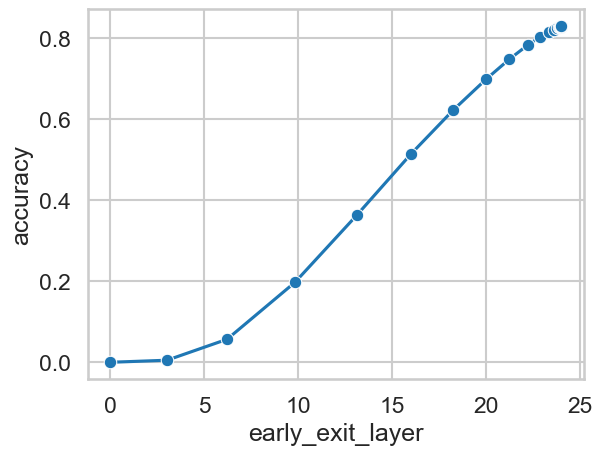

In [9]:
sns.lineplot(x= early_exit['early_exit_layer'],
             y=early_exit['accuracy'],
             marker='o')

<Axes: xlabel='layer_index'>

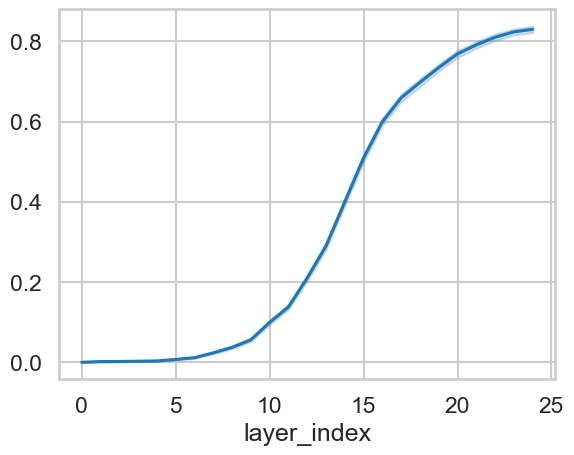

In [10]:
sns.lineplot(x=df['layer_index'],
             y=df['pred'] == df['label'])

<Axes: xlabel='layer_index', ylabel='p'>

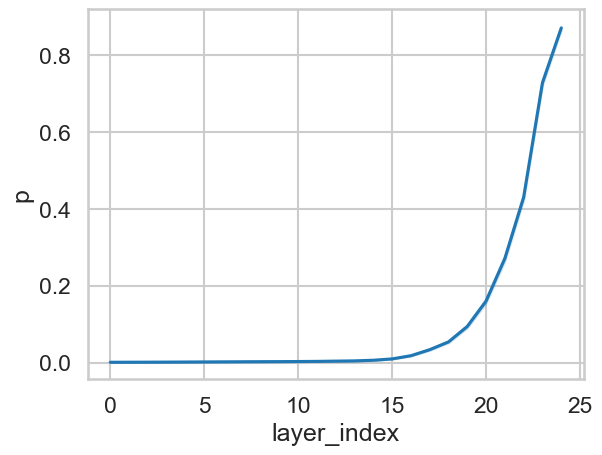

In [11]:
sns.lineplot(x=df['layer_index'],
             y=df['p'])

In [12]:
df['last_hidden_state'] = df.groupby('input_index')['hidden_state'].transform('last')
df['hidden_state_dist'] = df.progress_apply(
    lambda row: np.linalg.norm(np.array(row['hidden_state']) -
                               np.array(row['last_hidden_state'])),
    axis=1
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226175/226175 [00:16<00:00, 13839.06it/s]


<Axes: xlabel='layer_index', ylabel='hidden_state_dist'>

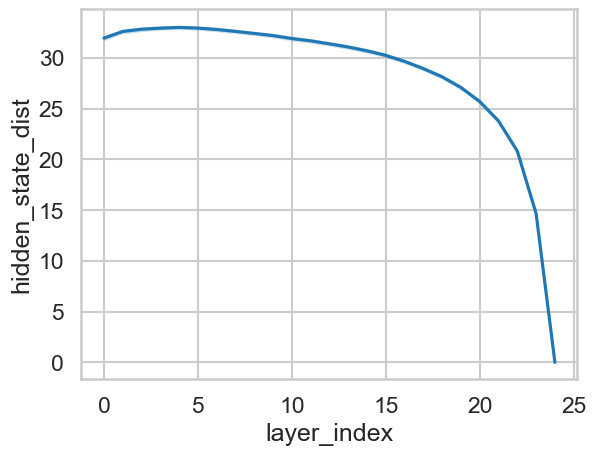

In [13]:
sns.lineplot(x=df['layer_index'],
             y=df['hidden_state_dist'])

In [14]:
df_train = df.iloc[: int(len(df) * 0.8)]
df_test = df.iloc[int(len(df) * 0.8):]

len(df_train), len(df_test)

(180940, 45235)

In [15]:
projectors = []
for layer_index in trange(df_train['layer_index'].max() + 1):
    df_to_use = df_train[df_train['layer_index'] == layer_index]
    X = np.stack(df_to_use['hidden_state'])
    y = np.stack(df_to_use['last_hidden_state'])
    projectors.append(LinearRegression().fit(X, y))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:54<00:00,  4.59s/it]


In [16]:
df_test['proj_hidden_state'] = df_test.progress_apply(
    lambda row: projectors[row['layer_index']].predict([row['hidden_state']])[0],
    axis=1
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45235/45235 [00:23<00:00, 1893.81it/s]
/var/folders/3t/tc9ht2z16psg1c40dl47_pmm0000gn/T/ipykernel_92125/881681050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['proj_hidden_state'] = df_test.progress_apply(


In [17]:
df_test['proj_pred'] = df_test['proj_hidden_state'].progress_apply(
    lambda proj_hidden_state: predict(torch.Tensor(proj_hidden_state))['pred']
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45235/45235 [00:02<00:00, 19053.86it/s]
/var/folders/3t/tc9ht2z16psg1c40dl47_pmm0000gn/T/ipykernel_92125/1763133482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['proj_pred'] = df_test['proj_hidden_state'].progress_apply(


<Axes: xlabel='layer_index'>

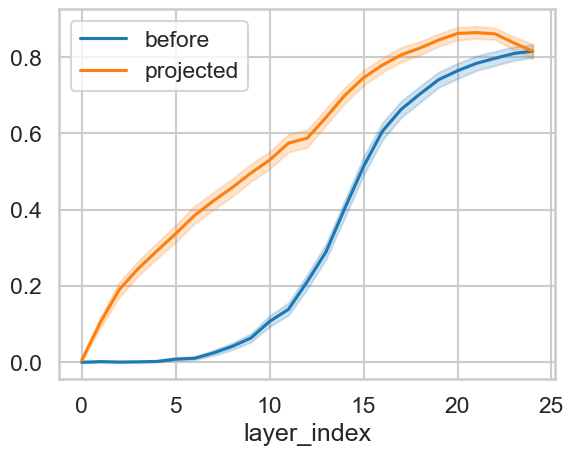

In [18]:
sns.lineplot(x=df_test['layer_index'],
             y=df_test['pred'] == df_test['label'],
             label='before')

sns.lineplot(x=df_test['layer_index'],
             y=df_test['proj_pred'] == df_test['label'],
             label='projected')

In [19]:
early_exit_before = get_early_exit(df_test, 'pred')
early_exit_proj = get_early_exit(df_test, 'proj_pred')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 30.00it/s]


<Axes: xlabel='early_exit_layer', ylabel='accuracy'>

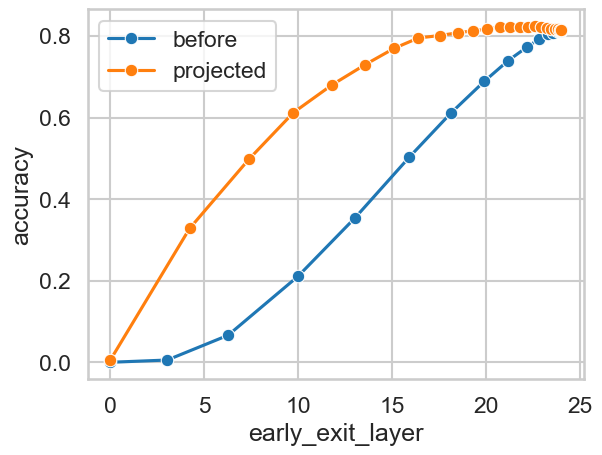

In [20]:
sns.lineplot(x= early_exit_before['early_exit_layer'],
             y=early_exit_before['accuracy'],
             marker='o',
             label='before')

sns.lineplot(x= early_exit_proj['early_exit_layer'],
             y=early_exit_proj['accuracy'],
             marker='o',
             label='projected')